In [1]:
from SyMBac.PSF import get_condensers, get_phase_contrast_kernel
from SyMBac.general_drawing import get_space_size, convolve_rescale
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from SyMBac.phase_contrast_drawing import draw_scene, generate_PC_OPL, make_images_same_shape
from SyMBac.phase_contrast_drawing import draw_scene, generate_PC_OPL, make_images_same_shape, generate_training_data

import pickle
import matplotlib.pyplot as plt
from SyMBac.misc import get_sample_images
import numpy as np

cell_timeseries_properties_file = open("cell_timeseries_properties.p", "rb")
cell_timeseries_properties = pickle.load(cell_timeseries_properties_file)
cell_timeseries_properties_file.close()

main_segments_file = open("main_segments.p", "rb")
main_segments = pickle.load(main_segments_file)
main_segments_file.close()

/home/georgeos/miniconda3/envs/symbac/lib/python3.9/site-packages/SyMBac/PSF.py:88: RuntimeWarning: invalid value encountered in divide
  kernel1 = 2*jv(1,rr)/(rr)
/home/georgeos/miniconda3/envs/symbac/lib/python3.9/site-packages/SyMBac/PSF.py:91: RuntimeWarning: invalid value encountered in divide
  kernel2 = 2*(R-W)**2/R**2 * jv(1,(R-W)**2/R**2 * rr)/rr


Text(0.5, 1.0, 'Phase contrast kernel')

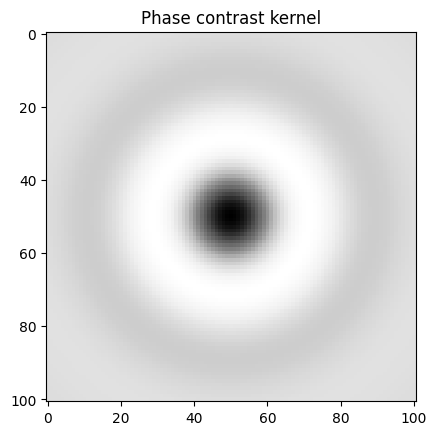

In [2]:
## Fixed parameters given by the scope and camera
condensers = get_condensers()
W, R, diameter = condensers["Ph3"]
radius = 50 #I've found 50 to be the best kernel size to optimise convolution speed while maintaining accuracy
λ = 0.75
resize_amount = 3
pix_mic_conv = 0.0655 #0.108379937 micron/pix for 60x, 0.0655 for 100x
scale = pix_mic_conv / resize_amount 
NA=1.45
n = 1.4

## Free parameters given by the undefined apodisation of the objective. 
## If unsure, leave this unchanged
min_sigma = 0.42*0.6/6 / scale #micron
sigma = min_sigma*15

kernel_params = (R,W,radius,scale,NA,n,sigma,λ) #Put into a tuple for easy use later
temp_kernel = get_phase_contrast_kernel(*kernel_params)
plt.imshow(temp_kernel, cmap="Greys_r")
plt.title("Phase contrast kernel")

In [3]:
do_transformation = True
offset = 30
label_masks = True
space_size = get_space_size(cell_timeseries_properties)
scenes = Parallel(n_jobs=13)(delayed(draw_scene)(
    cell_properties, do_transformation, space_size, offset, label_masks) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw:'))

Scene Draw::   0%|          | 0/998 [00:00<?, ?it/s]

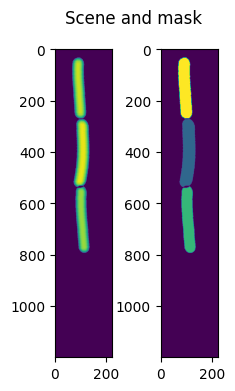

In [4]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2.5,4))
fig.suptitle('Scene and mask')
ax1.imshow(scenes[-1][0])
ax2.imshow(scenes[-1][1])
plt.show()

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


(256, 46)


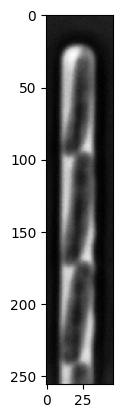

In [5]:
real_image = get_sample_images()["E. coli 100x"]
print(real_image.shape)
plt.imshow(real_image,cmap="Greys_r")
plt.show()

In [6]:
media_multiplier=30
cell_multiplier=1
device_multiplier=-50
y_border_expansion_coefficient = 1.9
x_border_expansion_coefficient = 1.4


temp_expanded_scene, temp_expanded_scene_no_cells, temp_expanded_mask = generate_PC_OPL(
   main_segments=main_segments,
    offset=offset,
    scene = scenes[-3][0],
    mask = scenes[-3][0],
    media_multiplier=media_multiplier,
    cell_multiplier=cell_multiplier,
    device_multiplier=cell_multiplier,
    y_border_expansion_coefficient = y_border_expansion_coefficient,
    x_border_expansion_coefficient = x_border_expansion_coefficient,
    fluorescence=False,
    defocus=2
)


### Generate temporary image to make same shape
convolved = convolve_rescale(temp_expanded_scene, temp_kernel, 1/resize_amount, rescale_int = True)
real_resize, expanded_resized = make_images_same_shape(real_image,convolved, rescale_int=True)

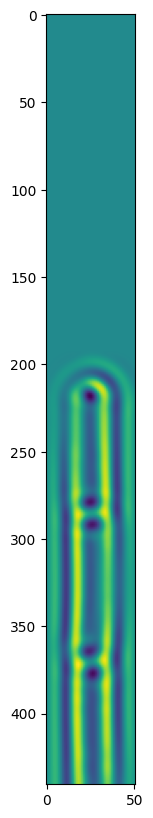

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(convolved)

In [8]:
#import napari
#viewer = napari.view_image(real_resize)
#media_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "media")
#cell_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "cell")
#device_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "device")

In [9]:
#real_media_mean = real_resize[np.where(media_label.data)].mean()
#real_cell_mean = real_resize[np.where(cell_label.data)].mean()
#real_device_mean = real_resize[np.where(device_label.data)].mean()
#real_means = np.array((real_media_mean, real_cell_mean, real_device_mean))
#real_media_var = real_resize[np.where(media_label.data)].var()
#real_cell_var = real_resize[np.where(cell_label.data)].var()
#real_device_var = real_resize[np.where(device_label.data)].var()
#real_vars = np.array((real_media_var, real_cell_var, real_device_var))

#image_params = (real_media_mean, real_cell_mean, real_device_mean, real_means, real_media_var, real_cell_var, real_device_var, real_vars)

In [10]:
import pickle
#image_params_file = open('image_params.p', 'wb')
#pickle.dump(image_params, image_params_file)
#image_params_file.close()

In [11]:
image_params_file = open("image_params.p", "rb")
image_params = pickle.load(image_params_file)
image_params_file.close()

In [12]:
from SyMBac.optimisation import manual_optimise

In [13]:
params = manual_optimise(
    scenes = scenes, 
    scale = scale, 
    offset = offset, 
    main_segments = main_segments, 
    kernel_params = kernel_params, 
    min_sigma = min_sigma,
    resize_amount = resize_amount, 
    real_image = real_image, 
    image_params = image_params, 
    x_border_expansion_coefficient = x_border_expansion_coefficient, 
    y_border_expansion_coefficient = y_border_expansion_coefficient
)

In [14]:
params

interactive(children=(IntSlider(value=75, description='media_multiplier', max=300, min=-300), FloatSlider(valu…

In [ ]:
generate_training_data(
    interactive_output = params, 
    sample_amount = 0.05, 
    randomise_hist_match = False, 
    randomise_noise_match = True, 
    sim_length = 1000, 
    burn_in = 100, 
    n_samples =  300, 
    save_dir = "/tmp/", 
    in_series=False)